In [ ]:
# TODO
# GPU + docker

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir tb_logs/my_model/version_97

In [1]:
import import_ipynb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.optim import Adam, SGD

from sampler import *
from data_modules import *
from callbacks import *

In [2]:
def generate_data(n, output_format):
    local = sample_no_signalling(n, True, output_format)
    non_local = sample_no_signalling(n, False, output_format)
    data = local + non_local
    targets = [0] * n + [1] * n
    return data, targets

In [ ]:
data, targets = generate_data(1000, 2)

In [3]:
class ConvNet(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = (3,3))
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(3200, 100)
        self.fc2 = nn.Linear(100, 10)
        self.sigmoid = nn.LogSoftmax(dim=1) #nn.Sigmoid()
        self.input_width, self.input_height = input_shape
        self.input_shape = input_shape
        
    def features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #x = self.pool(F.relu(self.conv2(x)))
        #x = self.pool(F.relu(self.conv3(x)))
        
        
        #x = self.pool(F.relu(self.conv3(x)))
        #x = self.pool(F.relu(self.conv3(x)))
        #x = self.pool(F.relu(self.conv3(x)))
        return x
    
    def get_features_dim(self):
        return self.features(np.zeros(shape=(1, *self.input_shape))).shape()
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) #self.sigmoid(x)

In [64]:
ConvNetBinaryClassification((200,100))

ConvNetBinaryClassification(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=29440, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (sigmoid): Sigmoid()
)

In [72]:
class ConvNetBinaryClassification(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = (3,3))
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)
        #self.input_width, self.input_height = input_shape
        self.input_shape = input_shape
        
        self.fc1 = nn.Linear(np.prod(self.get_features_dim()), 100)
        self.fc2 = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()

        
    def features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        return x
    
    def get_features_dim(self):
        return self.features(torch.zeros(size=(1, 1, *self.input_shape))).shape
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return self.sigmoid(x)

In [94]:
class MLP(nn.Module):
    def __init__(self, input_len, hidden_len):
        super().__init__()
        self.fc1 = nn.Linear(input_len, hidden_len)
        self.fc2 = nn.Linear(hidden_len, hidden_len)
        self.fc3 = nn.Linear(hidden_len, 10)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = x.float()
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)

In [95]:
MLP(16,1)

MLP(
  (fc1): Linear(in_features=16, out_features=1, bias=True)
  (fc2): Linear(in_features=1, out_features=1, bias=True)
  (fc3): Linear(in_features=1, out_features=10, bias=True)
  (sigmoid): Sigmoid()
)

In [73]:
from torchmetrics import Accuracy
from torch.nn import BCEWithLogitsLoss

class Classifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss = torch.nn.BCELoss()
        self.acc = Accuracy()
        
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        return SGD(self.parameters(), lr=1e-3)
        
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_hat = self.model(x)
        y = y.float().unsqueeze(1)
        loss = self.loss(y_hat, y)
        self.log('train_loss', loss)
        self.log('train acc', self.acc(torch.round(y_hat), y.int()))
        return loss

#     def validation_step(self, val_batch, batch_idx):
#         x, y = val_batch
#         y_hat = self.model(x)
#         y = y.float().unsqueeze(1)
#         val_loss = self.loss(y_hat, y)
#         self.log('val loss', val_loss)
#         self.log('val acc', self.acc(torch.round(y_hat), y.int()))

#         return val_loss
    
#     def test_step(self, batch, batch_idx):
#         x, y = batch

#         y_hat = self.model(x)
#         y = y.float().unsqueeze(1)
#         loss = self.loss(y_hat, y)
#         output = dict({
#                 'test_loss': loss,
#             'test_acc': self.acc(torch.round(y_hat), y.int()),        })
#         return output

In [5]:
from pl_bolts.callbacks import PrintTableMetricsCallback
from pytorch_lightning.loggers import WandbLogger 
from pytorch_lightning.loggers import TensorBoardLogger
from data_modules import MyDatasetOfImages
logger = TensorBoardLogger("tb_logs", name="my_model")
transform = transforms.Compose([
    transforms.ToTensor(),
#    transforms.Normalize([0,0,0], [1,1,1])
#    transforms.Resize(100)
])
dm = MNISTDataModule()
clf = Classifier(ConvNet())
trainer = pl.Trainer(max_epochs=40,
                     gpus=1, callbacks=[PrintTableMetricsCallback2(5)],
                     logger=logger)
trainer.fit(clf, dm)

/home/johnny/.virtualenvs/jup/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/johnny/.virtualenvs/jup/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:116: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | ConvNet          | 358 K 
1 | loss  | CrossEntropyLoss | 0     
2 | acc   | Accuracy         | 0     
-----------------------

Training: 0it [00:00, ?it/s]

train_loss│train acc
────────────────────
1.0567699670791626│0.5833333134651184
train_loss│train acc
────────────────────
0.23889465630054474│0.9583333134651184
train_loss│train acc
────────────────────
0.04274541512131691│0.9583333134651184
train_loss│train acc
────────────────────
0.022321850061416626│1.0


In [13]:
iterable = iter(dm.train_dataloader())
x, y = next(iterable)
a = clf.model.features(x)
print(y)

tensor([5, 6, 8, 7, 7, 1, 1, 8, 6, 1, 7, 2, 6, 7, 7, 1, 5, 4, 9, 7, 5, 1, 3, 6,
        2, 1, 2, 5, 7, 1, 9, 7])


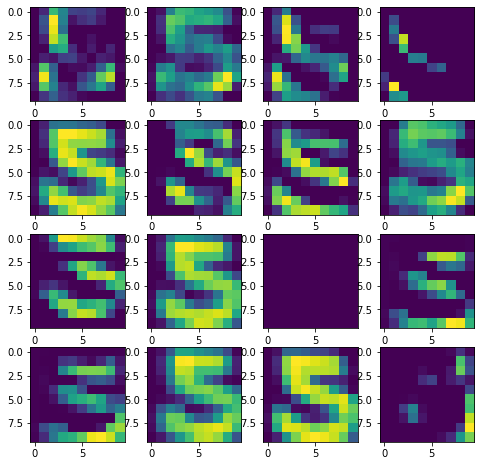

In [88]:
plt.figure(figsize=(8, 8))
for i in range(16):
    ax = plt.subplot(4,4,i+1)
    ax.imshow(a[0,i,:,:].detach().numpy())

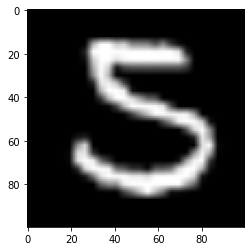

In [87]:
plt.imshow(x[0,0,:,:], cmap='gray')

In [75]:
data2, targets2 = generate_data(10000, 2)

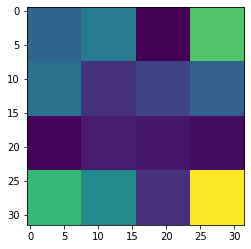

In [93]:
plt.imshow(data2[0])

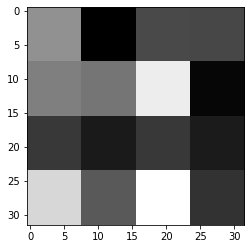

In [37]:
plt.imshow(data2[0], cmap='gray')

In [76]:
from pl_bolts.callbacks import PrintTableMetricsCallback
from pytorch_lightning.loggers import WandbLogger 
from pytorch_lightning.loggers import TensorBoardLogger
from data_modules import MyDatasetOfImages
logger = TensorBoardLogger("tb_logs", name="my_model")
transform = transforms.Compose([
    transforms.ToTensor(),
#    transforms.Normalize([0,0,0], [1,1,1])
#    transforms.Resize(100)
])

dm2 = MyDataModule(data2, targets2, transform, 16, MyDatasetOfImages)
clf2 = Classifier(ConvNetBinaryClassification((32,32)))
trainer2 = pl.Trainer(max_epochs=200, 
                     callbacks=[PrintTableMetricsCallback2(20)],
                     logger=logger)
trainer2.fit(clf2, dm2)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type                        | Params
------------------------------------------------------
0 | model | ConvNetBinaryClassification | 144 K 
1 | loss  | BCELoss                     | 0     
2 | acc   | Accuracy                    | 0     
------------------------------------------------------
144 K     Trainable params
0         Non-trainable params
144 K     Total params
0.576     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

train_loss│train acc
────────────────────
0.6989080905914307│0.4000000059604645
train_loss│train acc
────────────────────
0.6795278787612915│0.6600000262260437
train_loss│train acc
────────────────────
0.6086239218711853│0.8199999928474426
train_loss│train acc
────────────────────
0.21339932084083557│0.9200000166893005
train_loss│train acc
────────────────────
0.20001429319381714│0.9200000166893005


In [77]:
features = clf2.model.features(next(iter(dm2.train_dataloader()))[0])

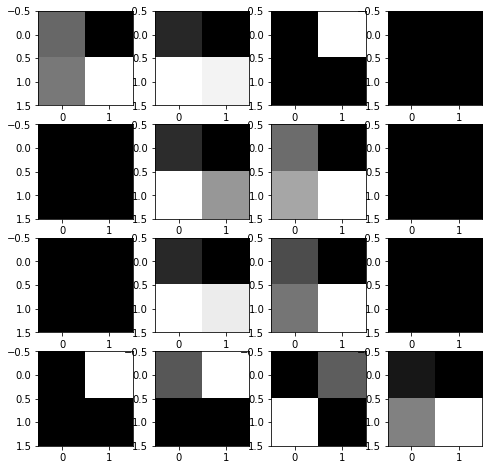

In [78]:
plt.figure(figsize=(8, 8))
for i in range(16):
    ax = plt.subplot(4,4,i+1)
    ax.imshow(features[2,i,:,:].detach().numpy(), cmap='gray')

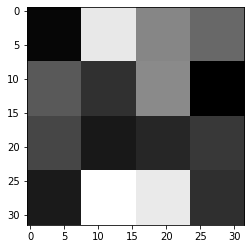

In [91]:
plt.imshow(next(iter(dm2.train_dataloader()))[0][0][0], cmap='gray')